# Formating Airbnb extracts

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar

from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
import seaborn as sns


## Formating functions

### Importing the historical data

In [2]:
"""Importing the an excel version of the historic data"""
file = "data/historic_data_copy.xls"
df = pd.read_excel(file)

### Formatting the header & dates

In [3]:
def format_header(df):
    """Translation of the columns name in english"""
    columns_en = [
        "Confirmation_Code",
        "Status",
        "Guest",
        "Contact",
        "Adults",
        "Children",
        "Infants",
        "Start_Date",
        "End_Date",
        "Number_of_Nights",
        "Reserved",
        "Advertisement",
        "Revenue"
    ]

    """Renaming teh columns"""
    df.columns = columns_en
    
    return df
    

In [4]:
def format_date(df):
    """Changing dates to datetime format"""
    df[['Start_Date', 'End_Date', 'Reserved']] = df[['Start_Date', 'End_Date', 'Reserved']].apply(pd.to_datetime)
    
    return df

### Formating the revenue column

In [5]:
def revenue_formating(df):    
    """Removing the 4 last characters in the revenue string"""
    df['Revenue']=df['Revenue'].str[:-5]

    """Removing ',ÄØ' in df['Revenue']"""
    modified_rev = df[df['Revenue'].str.contains('ÄØ')]['Revenue'].str[0] +\
                    df[df['Revenue'].str.contains('ÄØ')]['Revenue'].str[4:]
    for i in modified_rev.index:
        df.iloc[i, 12] = modified_rev[i]

    """Converting the revenue into float"""
    df['Revenue'] = df['Revenue'].str.replace(',', '.').astype(float)
    
    return df

### Adding Owner column

In [6]:
def add_owner(df):
    """Importing the apartment matiching index """
    apartments = "data/apartments.xls"
    match_df = pd.read_excel(apartments)

    df = pd.merge(df, match_df[['Apartment Name', 'Ad name 1', 'Owner']], how="left", left_on='Advertisement', right_on= 'Ad name 1')
    df = pd.merge(df, match_df[['Apartment Name', 'Ad name 2', 'Owner']], how="left", left_on='Advertisement', right_on= 'Ad name 2')

    df['Owner'] = df['Owner_x'].combine_first(df['Owner_y'])

    df.drop(columns=['Ad name 1', 'Ad name 2', 'Owner_x', 'Owner_y'], inplace=True)

    modified_code = df[df['Apartment Name_y'].notnull()]['Apartment Name_y']
    for i in modified_code.index:
        df.iloc[i, 13] = modified_code[i]

    df = df.rename(columns= {'Apartment Name_x':'Apartment_code'})
    df.drop(columns=['Apartment Name_y'], inplace=True)
    
    return df

### Status formating

In [7]:
def status_formating(df):
    translation_map = {
        'Ancien voyageur': 'Past traveler',
        'Annul√©e par le voyageur': 'Cancelled by the traveler',
        'Annul√©e par Airbnb': 'Cancelled by Airbnb',
        'Modification de voyage envoy√©e': 'Trip modification sent',
        'Demande de modification de voyage': 'Trip modification request',
        'Laissez un commentaire sur le voyageur (expire bient√¥t)': 'Leave a comment on the traveler (expires soon)',
        'En attente de commentaire du voyageur': 'Awaiting comment from the traveler',
        'S√©jour en cours': 'Stay in progress',
        'Laissez un commentaire sur le voyageur': 'Leave a comment on the traveler',
        'Confirm√©e': 'Confirmed'
    }
    df['Status'] = df['Status'].map(translation_map)

    df.drop(index=df[df.Revenue == 0].index, inplace=True)
    return df

### Removing irrelevant columns

In [8]:
def remove_columns(df):
    df.drop(columns=['Guest', 'Contact', 'Adults', 'Children', 'Infants', 'Advertisement'], inplace=True)
    return df

## Full formating and csv appending

### Creating historic csv

In [9]:
def full_formating(df):
    df = format_header(df)
    df = format_date(df)
    df = revenue_formating(df)
    df = add_owner(df)
    df = status_formating(df)
    df = remove_columns(df)
    
    return df

In [10]:
#df = full_formating(df)

In [11]:
#df.to_csv('data/historic_data_cleaned.csv', index = False)

### Adding to the historic

In [22]:
file = "data/reservations-4.csv"
df_to_add = pd.read_csv(file)

df_to_add = format_header(df_to_add)

df_to_add.Start_Date = pd.to_datetime(df_to_add.Start_Date, format='%d/%m/%Y', errors='coerce')
df_to_add.End_Date = pd.to_datetime(df_to_add.End_Date, format='%d/%m/%Y', errors='coerce')
df_to_add.Reserved = pd.to_datetime(df_to_add.Reserved, format='%Y-%m-%d', errors='coerce')

df_to_add.Revenue = df_to_add.Revenue.str.replace('\xa0€', '').str.replace(',', '.').str.replace('\u202f', '')

df_to_add =add_owner(df_to_add)

translation_map = {
    'Ancien voyageur': 'Past traveler',
    'Annulée par le voyageur': 'Cancelled by the traveler',
    'Annulée par Airbnb': 'Cancelled by Airbnb',
    'Modification de voyage envoyée': 'Trip modification sent',
    'Demande de modification de voyage': 'Trip modification request',
    'Laissez un commentaire sur le voyageur (expire bient√¥t)': 'Leave a comment on the traveler (expires soon)',
    'En attente de commentaire du voyageur': 'Awaiting comment from the traveler',
    'S√©jour en cours': 'Stay in progress',
    'Laissez un commentaire sur le voyageur': 'Leave a comment on the traveler',
    'Confirm√©e': 'Confirmed'
}
df_to_add['Status'] = df_to_add['Status'].map(translation_map)

df_to_add['Revenue'] = df_to_add['Revenue'].apply(pd.to_numeric, errors='coerce')

df_to_add.drop(index=df_to_add[df_to_add.Revenue == 0].index, inplace=True)

df_to_add = remove_columns(df_to_add)

df_to_add.head()

,Confirmation_Code,Status,Start_Date,End_Date,Number_of_Nights,Reserved,Revenue,Apartment_code,Owner
0,HM2ZPCMRRR,Past traveler,2022-08-24,2022-08-28,4,2022-08-20,192.06,Alia 36,Mohamed
1,HMM8NCHJFK,Past traveler,2022-08-21,2022-08-24,3,2022-08-20,132.13,Alia 36,Mohamed
2,HMKRCJK2D4,Past traveler,2022-08-10,2022-08-21,11,2022-08-07,542.23,Alia 36,Mohamed
3,HM2TNYJTWN,Past traveler,2022-08-06,2022-08-09,3,2022-08-06,160.09,Alia 36,Mohamed
4,HM8YJRPTHS,Past traveler,2022-07-28,2022-08-06,9,2022-07-27,481.06,Alia 36,Mohamed


In [23]:
import os

# Check if the file exists
file_path = 'data/historic_data_cleaned.csv'

# If file doesn't exist, write the header; otherwise, append without the header
if not os.path.exists(file_path):
    #df_to_add.to_csv(file_path, mode='w', header=True, index=False)
else:
    #df_to_add.to_csv(file_path, mode='a', header=False, index=False)  

In [40]:
#pd.read_csv('data/historic_data_cleaned.csv')

# Analysis

### Creating a table for daily revenue

In [30]:
def create_pivot(df, pivot_type = 'Revenue'):
    
    mode = (lambda pivot_type: 'sum' if pivot_type == 'Revenue' 
        else 'count' if pivot_type == 'Occupancy' 
        else "error mode not recognized")(pivot_type)

    
    #split data table into rows per days and create table for each day
    rows = []
    for i, row in df.iterrows():
        for single_date in pd.date_range(start=row.Start_Date, end=row.End_Date, inclusive= 'left'):
            rows.append({
                'Confirmation_Code': row['Confirmation_Code'],
                'Date': single_date,
                'Apartment_code': row['Apartment_code'],
                'Owner': row['Owner'],
                'Status': row['Status'],
                'Reserved': row['Reserved'],
                'Revenue': row['Revenue'] / (row['Number_of_Nights'])  # Split revenue equally per day
            })  

    df_days = pd.DataFrame(rows)
    # Add a Month column for aggregation
    df_days['Month'] = df_days['Date'].dt.to_period('M')

    # Pivot table to aggregate revenue per apartment and month
    pivot_table = df_days.pivot_table(
        index='Apartment_code',
        columns='Month',
        values='Revenue',
        aggfunc= mode,
        fill_value=0
    )
    return pivot_table

### Monthly reveue per apartment graphs

In [55]:
cleaned_df = pd.read_csv('data/historic_data_cleaned.csv')

In [56]:
cleaned_df['Revenue'] = cleaned_df.apply(
    lambda row: (row.Revenue - 50) if row.Apartment_code in ["Oumnia A2 17", "Palmeraie B9 A1"] 
    else (row.Revenue - 20), axis=1)
cleaned_df['Revenue'] = cleaned_df['Revenue']*0.8             

In [57]:
revenue_pivot = create_pivot(cleaned_df, pivot_type = 'Revenue')
df2 = create_pivot(cleaned_df, pivot_type = 'Revenue').transpose().reset_index()

In [100]:
analysis_table = revenue_threshold()

In [112]:
revenue_pivot.sum(axis=1)

Apartment_code
Alia 22            27714.456
Alia 36            21134.392
Alia 37            23030.512
Alia 41            28473.112
Menara 12            163.408
Menara 15          11955.704
Oumnia A2 17       28210.032
Palmeraie B9 A1     3178.280
dtype: float64

In [131]:
Number_of_months = []
for code in analysis_table.index:
    Number_of_months.append((revenue_pivot.loc[code] != 0).sum())
    
analysis_table['Number_of_months'] = Number_of_months
analysis_table['Total_threshold'] = analysis_table['Number_of_months']*analysis_table['Threshold']
analysis_table['Total_revenue'] = revenue_pivot.sum(axis=1)
analysis_table['Real_Earnings'] = analysis_table['Total_revenue']-analysis_table['Total_threshold']
analysis_table.drop(columns=['Number_of_months', 'Total_threshold'], inplace=True)
analysis_table = analysis_table.astype(int)

In [132]:
analysis_table

,Threshold,Total_revenue,Real_Earnings
Apartment_code,,,
Alia 22,650,27714,9514
Alia 36,850,21134,-5215
Alia 37,850,23030,-2469
Alia 41,900,28473,-326
Menara 12,1000,163,-836
Menara 15,1000,11955,4955
Oumnia A2 17,1800,28210,-4189
Palmeraie B9 A1,2000,3178,-2821


In [133]:
def highlight_positive_negative(val):
    """
    Color positive values green and negative values red.
    """
    color = 'green' if val > 0 else 'red' if val < 0 else 'black'
    return f'color: {color}'

styled_df = analysis_table.style.applymap(highlight_positive_negative)
styled_df

,Threshold,Total_revenue,Real_Earnings
Apartment_code,,,
Alia 22,650,27714,9514
Alia 36,850,21134,-5215
Alia 37,850,23030,-2469
Alia 41,900,28473,-326
Menara 12,1000,163,-836
Menara 15,1000,11955,4955
Oumnia A2 17,1800,28210,-4189
Palmeraie B9 A1,2000,3178,-2821


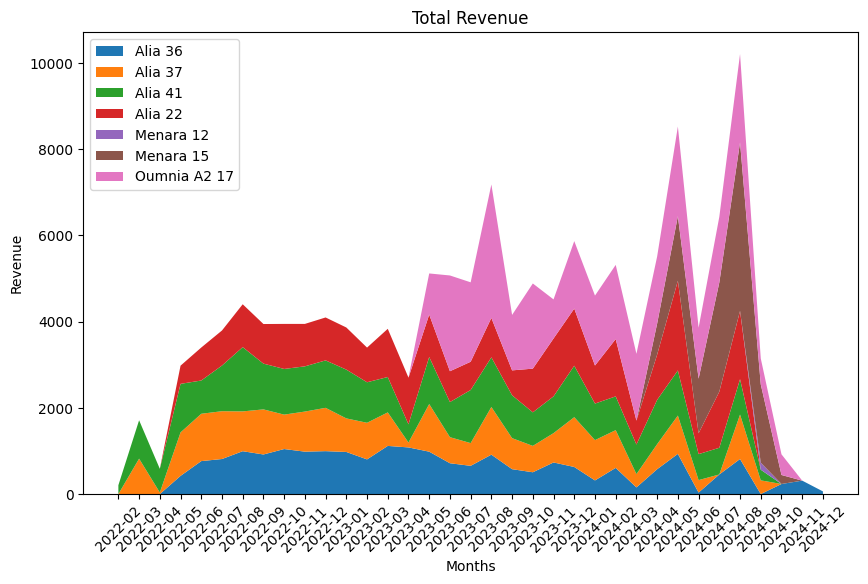

In [59]:
columns_to_plot = ['Alia 36', 'Alia 37', 'Alia 41','Alia 22', 'Menara 12', 'Menara 15', 'Oumnia A2 17']

plt.figure(figsize=(10, 6))
# Create a stacked line chart
plt.stackplot(df2.index, df2[columns_to_plot].T, labels=columns_to_plot)

# Add title and labels
plt.xticks(ticks=range(len(df2)), labels=df2['Month'].values, rotation=45);
plt.title('Total Revenue')
plt.xlabel('Months')
plt.ylabel('Revenue')

# Show legend
plt.legend(loc='upper left')

# Display the plot
plt.show()

### Colored pivot table functions

In [86]:
def rev_color_grid(df, thresholds):
    # Dictionary containing the name, row in thresholdsmeans_.iterrows()}

    # Dictionary to store the coloring criteria
    color_criteria = np.zeros_like(df, dtype=float)

    # Apply color logic based on comparison with row means
    for i in range(len(df)):
        row_threshold = thresholds.iloc[i][0]  # Get the mean for the current row
        
        for j in range(len(df.columns)):
            value = df.iloc[i, j]
            
            if pd.notnull(value):  # If the value is not NaN
                if value == 0:
                    color_criteria[i, j] = 0 # Grey
                elif value >= (row_threshold * 1.2):  # Greater than 20% above the row mean
                    color_criteria[i, j] = 2  # Green
                elif value <= (row_threshold * 0.8):  # Less than 20% below the row mean
                    color_criteria[i, j] = -2  # Red
                else:  # Between -20% and +20% of the row mean
                    color_criteria[i, j] = 1  # Yellow
            else:
                color_criteria[i, j] = 0  # Leave NaN as 0 for transparent
    return color_criteria 

In [82]:
def occ_color_grid(df):
    # Dictionary containing the name, row in thresholdsmeans_.iterrows()}

    # Dictionary to store the coloring criteria
    color_criteria = np.zeros_like(df, dtype=float)
    
    for j, n in enumerate(df.columns):
        col_threshold = round(calendar.monthrange(n.year, n.month)[1]*0.8,0)
        
        for i in range(len(df)):
            value = df.iloc[i, j]
            
            if pd.notnull(value):  # If the value is not NaN
                if value == 0:
                    color_criteria[i, j] = 0 # Grey
                elif value >= (col_threshold * 1.2):  # Greater than 20% above the monthly threshold
                    color_criteria[i, j] = 2  # Green
                elif value <= (col_threshold * 0.8):  # Less than 20% below the monthly threshold
                    color_criteria[i, j] = -2  # Red
                else:  # Between -20% and +20% of the row mean
                    color_criteria[i, j] = 1  # Yellow
            else:
                color_criteria[i, j] = 0  # Leave NaN as 0 for transparent

    return color_criteria

In [83]:
def revenue_threshold():
    thresholds = pd.DataFrame({
    'Apartment_code': ['Alia 22', 'Alia 36', 'Alia 37', 'Alia 41', 'Menara 12', 
                  'Menara 15', 'Oumnia A2 17', 'Palmeraie B9 A1'],
    'Threshold': [650, 850, 850, 900, 1000, 1000, 1800, 2000]})
    thresholds = thresholds.set_index('Apartment_code')
    return thresholds

In [91]:
def display_table(full_df, mode='Revenue', year=2022, owner='all'):
    
    if (owner=='Mohamed') | (owner=='Mounia'):
        full_df = full_df[full_df['Owner']==owner]
    
    full_pivot = create_pivot(full_df, pivot_type = mode)
    
    #Select only data for the selected year
    selected_time_range = full_pivot.columns[full_pivot.columns.year == year]
    df = full_pivot[selected_time_range].round(0).astype(int)
    
    
    if mode == 'Revenue':
        thresholds=revenue_threshold() #Extracting revenue averages
        color_criteria = rev_color_grid(df, thresholds)
    elif mode == 'Occupancy': 
        color_criteria = occ_color_grid(df)
    else:
        return 'Mode not recognized'

    # Define custom colors: Red, Grey, Yellow, Green
    colors_list = ["#E52916", "#dfe6e9", "#F1C40F", "#27AE60"]
    custom_colors = ListedColormap(colors_list)


    # Define boundaries for color mapping: -2, 0, 1, 2
    boundaries = [-2.5, -0.5, 0.5, 1.5, 2.5]  # The boundaries define where each color will start and end

    # Use BoundaryNorm to map the values (-2, 0, 1, 2) to the colors
    norm = BoundaryNorm(boundaries, custom_colors.N)

    # Display the DataFrame using imshow with custom colors
    fig, ax = plt.subplots(figsize=(12, 5))
    im = ax.imshow(color_criteria, cmap=custom_colors, norm=norm, aspect="auto")

    # Add text annotations for each cell
    for i in range(len(df)):
        for j in range(len(df.columns)):
            cell_value = df.iloc[i, j]
            ax.text(j, i, cell_value, ha="center", va="center", color="black")


    # Customize x-ticks and y-ticks
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(df.columns, rotation=45, ha="left", weight="bold")  # Rotate x-ticks
    ax.tick_params(axis="x", top=True, labeltop=True, bottom=False, labelbottom=False)  # Move x-ticks to the top
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(df.index, weight="bold")  # Make y-ticks smaller
    
    # Create custom legend patches
    legend_elements = [
        Patch(color=colors_list[0], label=f"More than 20% over threshold"),
        Patch(color=colors_list[1], label="NA - No data"),
        Patch(color=colors_list[2], label=f"Around threshold"),
        Patch(color=colors_list[3], label=f"More than 20% threshold")
        ]
    # Add the legend below the table
    ax.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=2)

    # Set title and adjust layout
    ax.set_title("Overview of the year")
    plt.tight_layout()
    plt.show()

    return

### Revenue Privot Tables

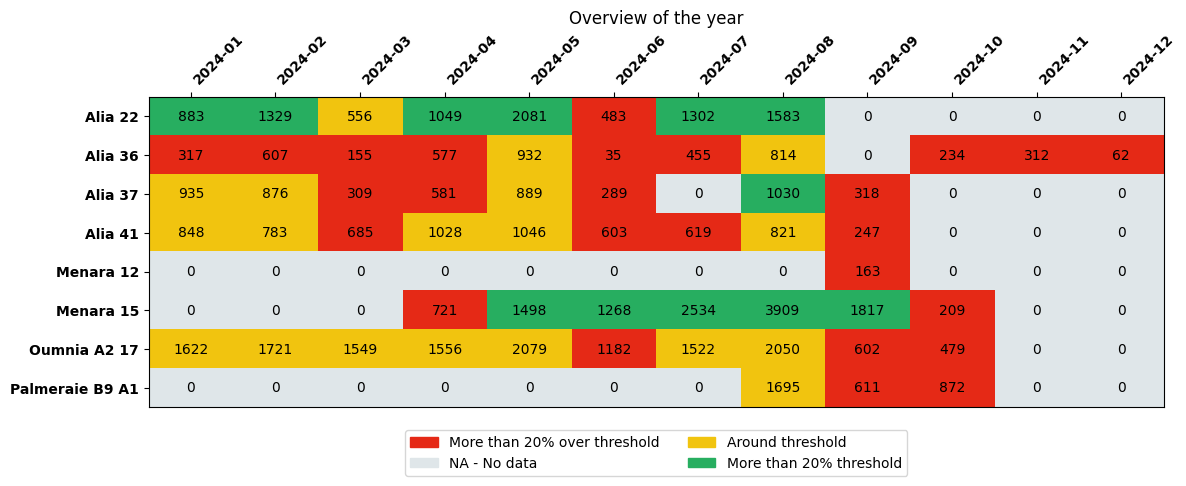

In [97]:
display_table(cleaned_df, mode='Revenue', year=2024)

### Occupancy Pivot Tables

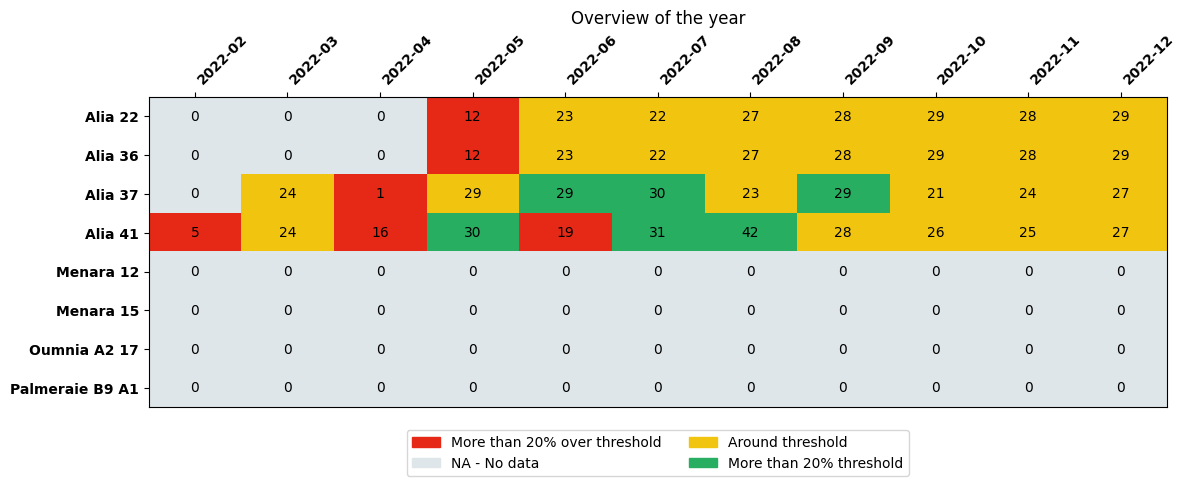

In [60]:
display_table(cleaned_df, mode='Occupancy', year=2022)

In [ ]:
cleaned_df[(cleaned_df['Apartment_code']=='Alia 36') | (cleaned_df['Apartment_code']=='Alia 37')]

### Next steps